In [17]:
import pandas as pd
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import os.path
from math import *
from operator import *

In [18]:
K = 2

In [19]:
class Node(object):
    def __init__(self,point,axis):
        self.point = point  # Datos Nodo
        self.left = None    # Nodo izquierdo
        self.right = None   # Nodo derecho
        self.axis = axis    # dimension de datos correspondiendo al nodo

In [20]:
def getHeight(node):
    if node == None:
        return -1
    else:
        return(1 + max(getHeight(node.left),getHeight(node.right)))

In [21]:
def build_kdtree(points, depth=0):
    n = len(points)
    axis = depth % K
    if n <= 0:
        return None
    if n == 1:
        return Node(points[0],axis)
    median = int(floor(len(points)/2))
    points.sort(key=lambda point: point[axis])
    node = Node(points[median],axis)
    node.left = build_kdtree(points[0:median], depth+1)
    node.right = build_kdtree(points[median+1:], depth+1)
    return node

In [22]:
def generate_data(node):
    texto = ""
    if node == None:
        return " "
    if node.left != None:
        texto+=str(node.point)[1:-1]+'\t'+str(node.left.point)[1:-1]+'\t'+str(node.axis)+'\n'
        texto+=generate_data(node.left)
    if node.right != None:
        texto+=str(node.point)[1:-1]+'\t'+str(node.right.point)[1:-1]+'\t'+str(node.axis)+'\n'
        texto+=generate_data(node.right)
    return texto

def create_archivo(archivo,texto):
    archivo = open(archivo, "w")
    archivo.write(texto)
    archivo.close()

In [23]:
def distance_squared(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    dx = x1 - x2
    dy = y1 - y2
    return dx * dx + dy * dy
    
def closest_point(all_points, new_point):
    best_point = None
    best_distance = None
    for current_point in all_points:
        current_distance = distance_squared(new_point, current_point)
        if best_distance is None or current_distance < best_distance:
            best_distance = current_distance
            best_point = current_point
    return best_point

In [24]:
def kdtree_naive_closest_point(node, point, depth=0, best=None):
    if node is None:
        return best
    axis = depth % K
    next_best = None
    next_branch = None
    if best is None or distance_squared(best, point) > distance_squared(node.point, point):
        next_best = node.point
    else:
        next_best = best
    if point[axis] < node.point[axis]:
        next_branch = node.left
    else:
        next_branch = node.right
    return kdtree_naive_closest_point(next_branch, point, depth + 1, next_best)

In [25]:
def closer_distance(pivot, p1, p2):
    if p1 is None:
        return p2
    if p2 is None:
        return p1
    d1 = distance_squared(pivot, p1)
    d2 = distance_squared(pivot, p2)
    if d1 < d2:
        return p1
    else:
        return p2

In [26]:
def kdtree_closest_point(node, point, depth=0):
    if node is None:
        return None
    axis = depth % K
    next_branch = None
    opposite_branch = None
    if point[axis] < node.point[axis]:
        next_branch = node.left
        opposite_branch = node.right
    else:
        next_branch = node.right
        opposite_branch = node.left
    best = closer_distance(point,
                           kdtree_closest_point(next_branch,
                                                point,
                                                depth + 1),
                           node.point)
    if distance_squared(point, best) > (point[axis] - node.point[axis]) ** 2:
        best = closer_distance(point,
                               kdtree_closest_point(opposite_branch,
                                                    point,
                                                    depth + 1),
                               best)
    return best

In [27]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):
    #if not nx.is_tree(G):
    #    raise TypeError('No se puede usar porque no es un arbol')
        #return None
    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))
        else:
            root = random.choice(list(G.nodes))
    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        #children = children.sort()
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [28]:
def graph_create(root,archivo):
    knode_i=str(root.point)[1:-1]
    plt.figure(figsize=(8,8))
    G = nx.Graph()
    G_0=nx.Graph()
    G_1=nx.Graph()
    data = pd.read_csv(archivo, sep="\t", header=None)
    size = int(len(data[[1]]))
    for row in range(size):
        if data[2][row] == 0: 
            G_0.add_node(data[0][row]) 
            G_1.add_node(data[1][row])
        if data[2][row] == 1: 
            G_1.add_node(data[0][row])
            G_0.add_node(data[1][row])
        G.add_edge(data[0][row],data[1][row])
    pos = hierarchy_pos(G,knode_i)
    options = {"edgecolors": "tab:gray", "node_size": 1200, "alpha": 1}
    nx.draw(G, pos=pos, with_labels=False)
    # nodes
    nx.draw_networkx_nodes(G, pos, nodelist=G_0, node_color="skyblue", **options)
    nx.draw_networkx_nodes(G, pos, nodelist=G_1, node_color="lightcoral", **options)
    # edges
    nx.draw_networkx_edges(G, pos, edge_color="tab:gray", arrows = True)
    # labels
    nx.draw_networkx_labels(G, pos, font_size=7)
    plt.suptitle('KD Tree', fontsize=13, fontweight ="bold")
    plt.savefig('KDTreeGrafo.png')
    plt.show()

In [29]:
POINTS_N = 30   # Numero de points
MIN_VAL = 0     # minimo valor coordenadas
MAX_VAL = 40    # maximo valor coordenadas
# ancho de línea para visualización K-D tree
LINE_WIDTH = [4., 3.5, 3., 2.5, 2., 1.5, 1., .5, .3]
DELTA = 2

In [30]:
def plot_tree(R,tree, min_x, max_x, min_y, max_y, prev_node, branch, depth=0):
    cur_node = tree.point
    left_branch = tree.left
    right_branch = tree.right
    if depth > len(LINE_WIDTH)-1:
        ln_width = LINE_WIDTH[len(LINE_WIDTH)-1]
    else:
        ln_width = LINE_WIDTH[depth]
    k = len(cur_node)
    axis = depth % k
    if axis == 0:
        if branch is not None and prev_node is not None:
            if branch:
                max_y = prev_node[1]
            else:
                min_y = prev_node[1]
        plt.plot([cur_node[0],cur_node[0]], [min_y,max_y], 
                 linestyle='-', color='#6BB3F4', linewidth=ln_width)
    elif axis == 1:
        if branch is not None and prev_node is not None:
            if branch:
                max_x = prev_node[0]
            else:
                min_x = prev_node[0]
        plt.plot([min_x,max_x], [cur_node[1],cur_node[1]], linestyle='-', color='#F08080', linewidth=ln_width)
    plt.plot(cur_node[0], cur_node[1], 'ko')
    if left_branch is not None:
        plot_tree(R,left_branch, min_x, max_x, min_y, max_y, cur_node, True, depth+1)
    if right_branch is not None:
        plot_tree(R,right_branch, min_x, max_x, min_y, max_y, cur_node, False, depth+1)


In [31]:
def plot_result(root, point, point_nn, output_dir: str) -> None:
    plt.figure('K-D Tree', figsize=(10., 10.))
    plt.axis([MIN_VAL - DELTA, MAX_VAL + DELTA,
              MIN_VAL - DELTA, MAX_VAL + DELTA])
 
    plt.grid(visible=True, which='major', color='0.75', linestyle='--')
    plt.xticks(range(MIN_VAL - DELTA, MAX_VAL + DELTA))
    plt.yticks(range(MIN_VAL - DELTA, MAX_VAL + DELTA))

    R=[]
    plot_tree(R,root, MIN_VAL-DELTA, MAX_VAL + DELTA, MIN_VAL - DELTA, MAX_VAL + DELTA, None, None)
 
    plt.plot(point[0], point[1], marker='o', color='#ff007f')
    circle = plt.Circle((point[0], point[1]), 0.3, facecolor='#ff007f',
                        edgecolor='#ff007f', alpha=0.5)
    plt.gca().add_patch(circle)
 
    circle = plt.Circle((point[0], point[1]), distance_squared(point, point_nn),
                        facecolor='#ffd83d', edgecolor='#ffd83d', alpha=0.5)
    plt.gca().add_patch(circle)

    plt.plot(point_nn[0], point_nn[1], 'go')
    circle = plt.Circle((point_nn[0], point_nn[1]), 0.3, facecolor='#33cc00',
                        edgecolor='#33cc00', alpha=0.5)
    plt.gca().add_patch(circle)
    plt.title('KD Tree')
    plt.savefig(os.path.join(output_dir, 'KDTree.png'))
    plt.show()
    plt.close()

(12, 7)
5


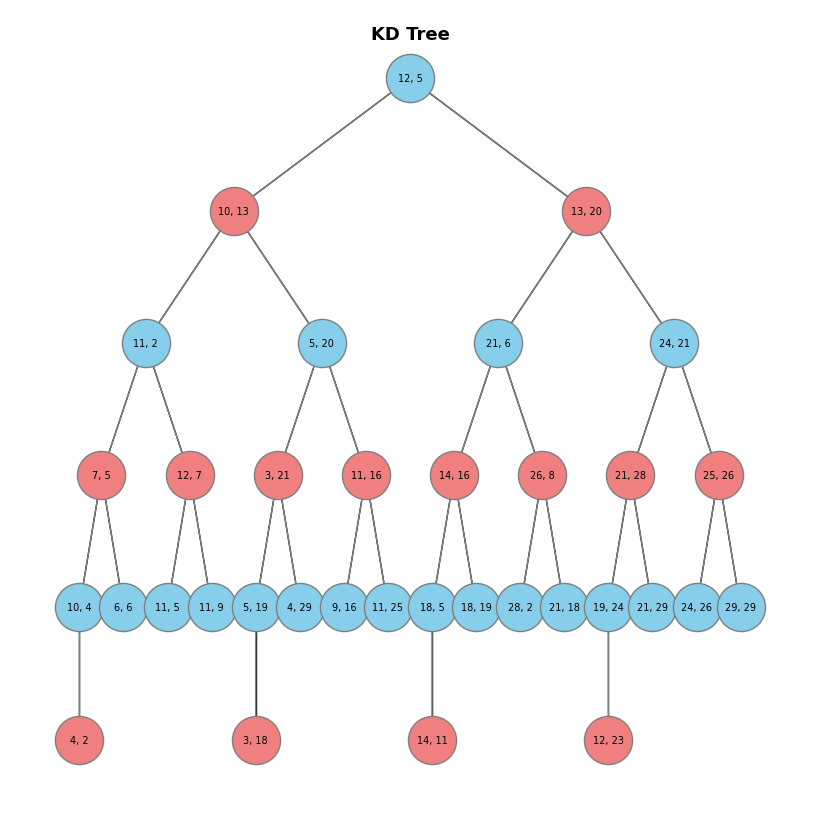

In [32]:
n = 35
min_val = 2
max_val = 30
delta = 2
dataset=[]#[(0.54,0.93),(0.96,0.86),(0.42,0.67),(0.11,0.53),(0.64,0.29),(0.27,0.75),(0.81,0.63)]

for i in range(n):
    x = int(random.randint(min_val,max_val))
    y = int(random.randint(min_val,max_val))
    dataset.append((x,y))

kdTree = build_kdtree(dataset, delta)
root = kdTree.point

pivot = (10,7)

found = kdtree_closest_point(kdTree, pivot)
alt = getHeight(kdTree)

lista_data = generate_data(kdTree)
create_archivo("dataset.csv", lista_data)
print(found)
print(alt)

graph_create(kdTree,'dataset.csv')

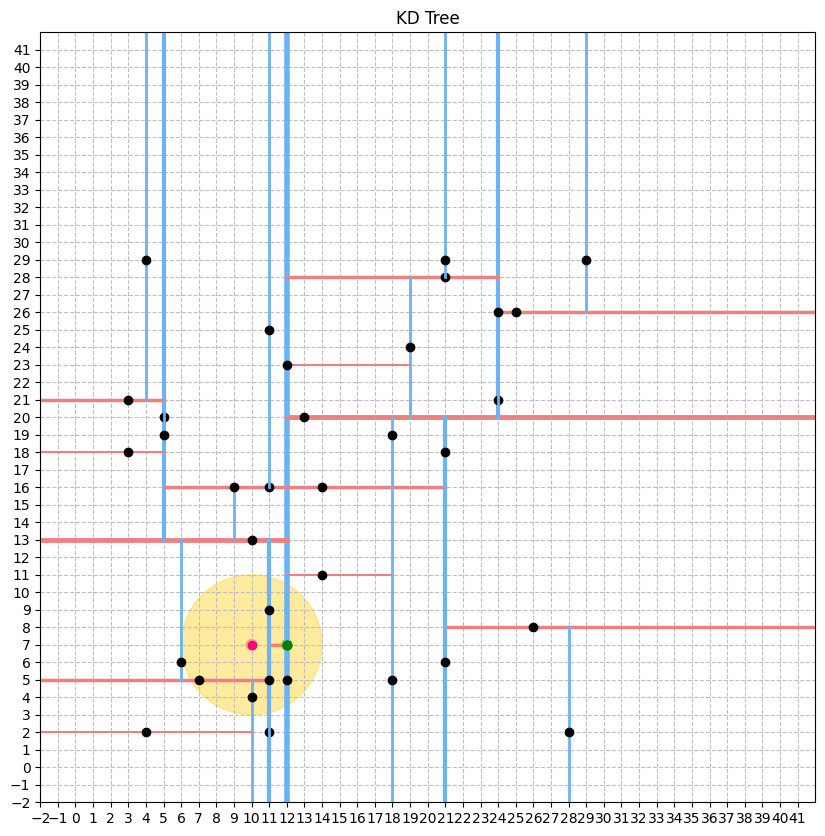

In [33]:
output_dir = 'C:/Users/luzma/Desktop/MAESTRIA/AED/FINAL/'
plot_result(kdTree, pivot, found, output_dir)